In [3]:
import sys
import os
# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))

In [4]:
# Import Model and Helper Functions
from model import Schelling
from helper_functions.segregation_clusters import *
from helper_functions.wealth_clusters import *
from helper_functions.percolation import *
from mesa.batchrunner import BatchRunner

In [5]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm

### Schelling Phase Diagram
![Schelling Phase Diagram](plots/Schelling_Phase_Diagram.png "Schelling Phase Diagram")
**SOURCE:** **Phase diagram of a Schelling segregation model (2009)** *L. Gauvin, J. Vannimenus and J.-P. Nadal*

**Control parameters:**
- Alpha
- Homophily
- Agent density

**Order parameters:**
- Segregation Coefficient
- Moran's I
- Variance-based wealth segregation meassure


# 0. Find the USA wealth distribution:
We have found that the wealth distribution of the USA closly resembles a log normal distribution [SOURCE]. To test the initial wealth distribution of our agents we have created the function ```test_USA_wealthDist(num_agents, mean, std_dev)```. We used this function to find the appropriate parameters (mean/standard deviation) of the distribution.

In [4]:
def plot_lognormal_dist(num_agents, mean, std_dev):
    """
    Test the distribution of initial wealth of agents
    We choose a lognormal distribution for the initial wealth of agents
    as it is a good approximation of the distribution of wealth in the USA
    """

    initial_wealth = []
    for i in range(num_agents):
        initial_wealth.append(np.random.lognormal(mean, std_dev))

    # Plotting the distribution
    plt.hist(initial_wealth, bins=30, color='#3f60af', edgecolor='black')
    plt.xlabel('Amount Wealth')
    plt.ylabel('Frequency')
    plt.title('Distribution of Initial Wealth')
    plt.show()

    return initial_wealth

def test_USAwealthDist(initial_wealth):
    """
    Tests the distribution of initial wealth of agents and plots the total wealth
    owned by each wealth class.
    
    Args:
        num_agents: Number of agents in the model
        mean: Mean of the logarithm of the distribution
        std_dev: Standard deviation of the logarithm of the distribution
    """

    # Calculate wealth thresholds for different wealth classes
    thresholds = np.percentile(initial_wealth, [99, 80, 60, 40, 20])

    # Categorize the wealth of each agent into different classes
    classes = np.zeros(len(initial_wealth))
    classes[initial_wealth >= thresholds[0]] = 5  # Top 1%
    classes[(initial_wealth >= thresholds[1]) & (initial_wealth < thresholds[0])] = 4  # Top 20% (excluding top 1%)
    classes[(initial_wealth >= thresholds[2]) & (initial_wealth < thresholds[1])] = 3  # Fourth 20%
    classes[(initial_wealth >= thresholds[3]) & (initial_wealth < thresholds[2])] = 2  # Middle class
    classes[(initial_wealth >= thresholds[4]) & (initial_wealth < thresholds[3])] = 1  # Second 20%
    classes[initial_wealth < thresholds[4]] = 0  # Bottom 20%

    # Calculate the total wealth owned by each wealth class
    wealth_by_class = [np.sum(np.array(initial_wealth)[classes == i]) for i in range(6)]
    
    # Plotting the total wealth owned by each wealth class
    class_labels = ['Bottom 20%', 'Second 20%', 'Middle class', 'Fourth 20%', 'Top 20%', 'Top 1%']
    
    plt.bar(class_labels, wealth_by_class, color='#dd4f5d', edgecolor='black')
    plt.xlabel('Wealth Class')
    plt.ylabel('Total Wealth')
    plt.title('Distribution of Initial Wealth by Wealth Class')

    plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels

    plt.tight_layout()  # Adjust spacing for better visibility of labels
    plt.show()

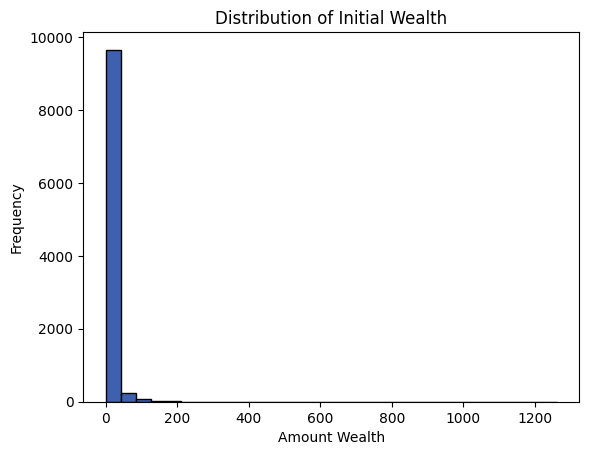

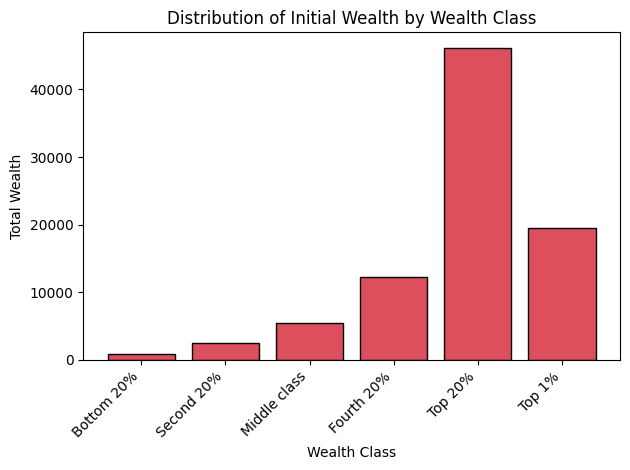

In [5]:
num_agents = 10000
mean = 1.0  # Mean of the logarithm of the distribution
std_dev = 1.5  # Standard deviation of the logarithm of the distribution
initial_wealth = plot_lognormal_dist(num_agents, mean, std_dev)
test_USAwealthDist(initial_wealth)

# 1. Simulation Visualizations*:
## Spatial visualization of the wealth distribution:
We created a 2D heatmap plot, to gain a better understanding of the spatial distribution of wealth over the entire system.
In this heatmap, the yellow cells represent the most wealthy agents, and the darker blue cells represent the poorest agents. If a cell has a wealth of 0, you are right to assume that the cell is empty, as an agent's wealth can never be 0. The function ```plot2D_modelWealth()``` plots the spatial wealth distribution, while the function ```plot2D_modelTypes()``` simply plots the spatial distribution of agent types (regular Schelling model).

*More simulation visualizations can be seen by running the command ```python3 run.py``` in your terminal, be aware you should be in the right directory ```\mesa-schelling```

In [5]:
def plot2D_modelWealth(model):
    """
    Plots a 2D density heatmap of the model.
        x-axis: x position
        y-axis: y position
        weights: wealth
    """

    # Extract data from model
    x_coords = np.array([agent.pos[0] for agent in model.schedule.agents])  # Agent x coords
    y_coords = np.array([agent.pos[1] for agent in model.schedule.agents])  # Agent y coords
    wealths = np.array([agent.wealth for agent in model.schedule.agents])   # Agent wealths 
    df = pd.DataFrame({'x_pos': x_coords, 'y_pos': y_coords, 'wealth': wealths})

    # Create the 2D density heatmap
    fig = px.density_heatmap(df, x='x_pos', y='y_pos', z='wealth', nbinsx=model.size, nbinsy=model.size)

    # Set axis labels
    fig.update_layout(
        height=720, width=720,
        xaxis_title='X pos', yaxis_title='Y pos', 
        coloraxis_colorbar_title='Wealth',
        title=f'Spatial wealth distribution (t={model.schedule.steps})'
    )

    # Show the plot
    fig.show()

def plot2D_modelTypes(model):
    """
    Plots the model as a 2D scatterplot.
        x-axis: x position
        y-axis: y position
        color: agent type
    """

    # Extract data from model
    positions = [agent.pos for agent in model.schedule.agents]
    types = [agent.type for agent in model.schedule.agents]

    # Create the 2D scatterplot
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 9)

    # Define agent colors
    agent_colors = {
        0: {'color': '#FF0000', 'label': 'Agent Type 0'},
        1: {'color': '#00FF00', 'label': 'Agent Type 1'},
        2: {'color': '#0000FF', 'label': 'Agent Type 2'},
        3: {'color': '#FFA500', 'label': 'Agent Type 3'},
        4: {'color': '#FF00FF', 'label': 'Agent Type 4'},
        5: {'color': '#00FFFF', 'label': 'Agent Type 5'},
        6: {'color': '#FFFF00', 'label': 'Agent Type 6'},
        7: {'color': '#800080', 'label': 'Agent Type 7'},
        8: {'color': '#008000', 'label': 'Agent Type 8'},
        9: {'color': '#FFC0CB', 'label': 'Agent Type 9'}
    }
    colors = [agent_colors[agent_type]['color'] for agent_type in types]

    ax.scatter(*zip(*positions), color=colors, s=10)
    ax.set_title(f'Schelling model (t={model.schedule.steps})', fontsize=10, fontweight='bold')
    ax.set_xlabel('X pos', fontsize=10)
    ax.set_ylabel('Y pos', fontsize=10)
    ax.set_xlim([0, model.size])
    ax.set_ylim([0, model.size])

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()

## Wealth distribution over time:
To visualize the evolution of wealth distribution during the model simulation, we implemented the function ```wealth_dist_lineplot```. This function creates a simple line plot of the total wealth of each agent type for each time step of the simulation.  

In [6]:
def wealth_dist_lineplot(model):
    """
    Creates a line plot of the wealth distribution over time.
    """

    # Extract data
    wealth_dist = model.datacollector.get_model_vars_dataframe()['wealth_dist']
    time = np.arange(len(wealth_dist))

    # Define agent colors
    agent_colors = {0: '#FF0000', 1: '#00FF00', 2: '#0000FF', 3: '#FFA500', 4: '#FF00FF', 5: '#00FFFF', 6: '#FFFF00', 7: '#800080', 8: "#008000", 9: "#FFC0CB"}
    colors = [agent_colors[agent_type] for agent_type in wealth_dist[0].keys()]

    # Creating the line plot
    for type in range(model.N):
        plt.plot(time, wealth_dist.apply(lambda x: x[type]), label=f'Agent-type {type}', color=colors[type])    

    # Adding labels and title
    plt.xlabel('Time')
    plt.ylabel('Wealth')
    plt.title('Wealth distribution over time')
    # Adding a legend
    plt.legend()
    # Displaying the chart
    plt.show()

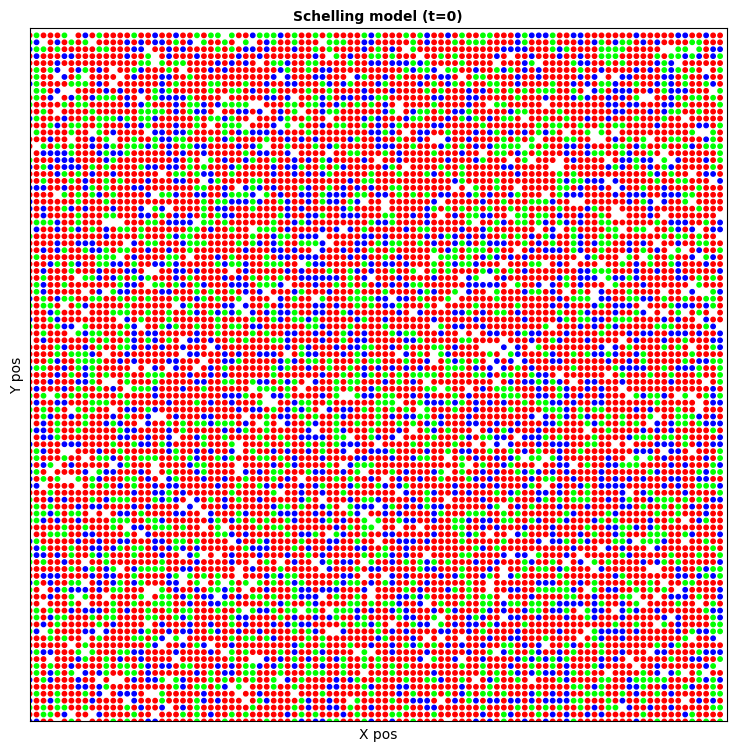

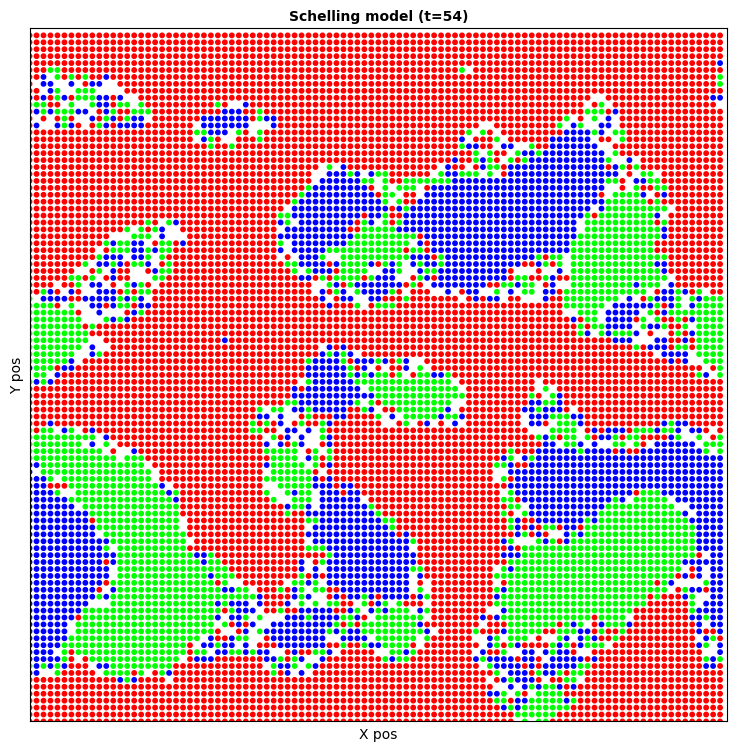

In [8]:
# Define model parameters
size = 100
density = 0.95
fixed_areas_pc = 0.0
population_sizes = [0.6, 0.2, 0.2] # Add extra weights for more agent types (up to 10)
homophily = 5
cluster_threshold = 4
alpha=0.99
stopping_threshold=5
server=False

# Create the model
model = Schelling(size, density, fixed_areas_pc, population_sizes, homophily, cluster_threshold, alpha, stopping_threshold, server)

# Plot starting type/wealth distribution
plot2D_modelTypes(model)
plot2D_modelWealth(model)

# Run the model
steps = 200
for i in range(steps):
    model.step()

# Plot ending type/wealth distribution
plot2D_modelTypes(model)
plot2D_modelWealth(model)


# 2. Segregation Clustering:
## Segregation coefficient
To measure the amount of segregation we use the segregation coefficient based on the article by Gauvin et al. (2009). We implemented the ```WeightedAverage``` to find the normalized weighted average of the cluster sizes. To find the segregation coefficient we need to average the normalized weighted average over multiple model runs.

In [29]:
def WeightedAverage(model):
    """
    Calculates the weighted average of cluster size. Works for multiple populations with different weights.
    """
    s = 0
    
    for i in model.cluster_sizes:
        a = 0
        
        # Squaring the cluster sizes and summing them per population
        for j in range(len(model.cluster_sizes[i])):
            a += model.cluster_sizes[i][j]**2
        
        # Finding the normalized weighted average for population i and adding them up to the others
        s += (1 / (model.grid.width * model.grid.height * model.pop_weights[i])**2) * a
    
    return s / model.N

## Moran's I
Another measure for clustering is Moran's I. It is a useful measure when working with two populations. Moran's I is defined as:
$$
I = \left(\frac{N_{tot}}{\sum_i\sum_j w_{i,j}}\right)\left(\frac{\sum_i\sum_jw_{i,j}(z_i-\bar{z})(z_j-\bar{z})}{\sum_i}(z_i-\bar{z})\right)
$$ Here, $N_{tot}$ denotes the total amount of agents, the sums are taken over all agents in the system, $w_{i,j}=1$ when agent $i$ and $j$ are neighbours, $z_i$ is 0 for the first population and $z_j$ is 1 for the second population. Finally, $\bar{z}$ is the average value of $z$ for all agents, which is equal to the fraction of the second population in the system. To calculated Moran's I we define ```MoransI```:

In [30]:
def MoransI(model):
    
    weight = model.pop_weights[1]
    N_tot = model.size*model.size*model.density
    
    a = 0
    b = 0
    c = 0
    
    for cell1 in model.grid.coord_iter():
        agent1, x1, y1 = cell1
        
        # Check whether content of cell is not None
        if agent1 == None:
                continue
        
        # Calculating the single sum below the division (c)       
        if agent1.type == 0:
            p = 1
        else:
            p = 0
        c += (p - weight)**2
        
        for cell2 in model.grid.coord_iter():
            agent2, x2, y2 = cell2
            
            # Check whether content of cell is not None
            if agent2 == None:
                continue
            
            # Check whether agent1 and agent2 are neighbors
            if (np.sqrt((x1-x2)**2)>1 or np.sqrt((x1-x2)**2)==0) or (np.sqrt((y1-y2)**2)>1 or np.sqrt((y1-y2)**2)==0):
                continue
            
            # Calculating the sums
            a += (agent1.type - weight)*(agent2.type - weight)
            b += 1
    
    MoransI = (N_tot/b)*(a/c)
    return MoransI

### Sub-RQ1: *At what **tolerance threshold** does segregation occur?*

For homophily values: [0 1 2 3 4 5 6 7 8]


100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


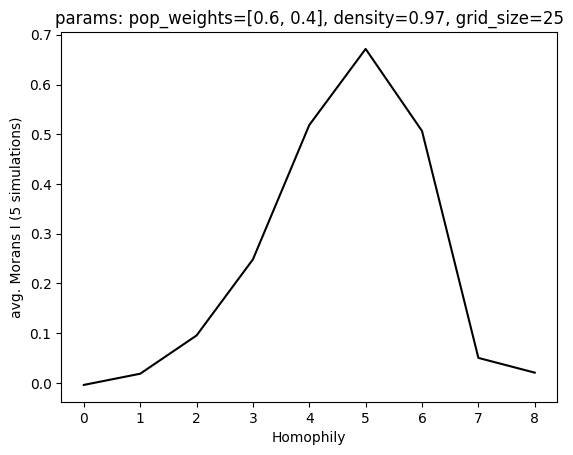

<Figure size 640x480 with 0 Axes>

In [32]:
num_runs = 5  # Number of model runs

# Define model parameters
size = 25
density = 0.97
fixed_areas_pc = 0.0
population_sizes = [0.6, 0.4] # Add extra weights for more agent types (up to 10)
cluster_threshold = 4
alpha=0.95
stopping_threshold=5
stats = False
server=False

homophily_values = np.linspace(0, 8, num=9, dtype=int)
print(f'For homophily values: {homophily_values}')

segregation_list = []

for homophily in tqdm(homophily_values):
    homophily_segregation = []

    for _ in range(num_runs):
        model = Schelling(size, density, fixed_areas_pc, population_sizes, homophily, cluster_threshold, alpha, stopping_threshold, stats, server)        
        for i in range(100):
            model.step()
        
        homophily_segregation.append(MoransI(model))

    average_segregation = np.mean(homophily_segregation)
    segregation_list.append(average_segregation)

plt.plot(homophily_values, segregation_list, 'k-')
plt.title(f'params: pop_weights={population_sizes}, density={density}, grid_size={size}')
plt.xlabel('Homophily')
plt.ylabel(f'avg. Morans I ({num_runs} simulations)')
plt.show()
plt.savefig('RQ1_MoransI_vs_Homophily.png')

### Sub-RQ2: *At what **population density** does segregation occur?*

For density values: [0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99]


100%|██████████| 90/90 [01:37<00:00,  1.08s/it]


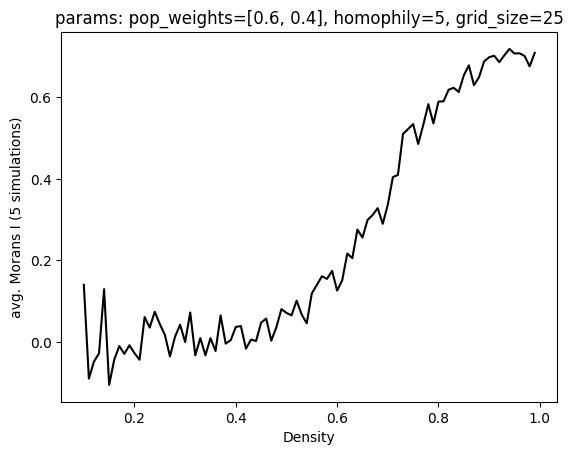

<Figure size 640x480 with 0 Axes>

In [10]:
num_runs = 5  # Number of model runs

# Define model parameters
size = 25
homophily = 5
fixed_areas_pc = 0.0
population_sizes = [0.6, 0.4] # Add extra weights for more agent types (up to 10)
cluster_threshold = 4
alpha=0.95
stopping_threshold=5
stats = False
server=False

density_values = np.linspace(0.1, 0.99, num=90)
print(f'For density values: {density_values}')

segregation_list = []
for density in tqdm(density_values):
    density_segregation = []

    for _ in range(num_runs):
        model = Schelling(size, density, fixed_areas_pc, population_sizes, homophily, cluster_threshold, alpha, stopping_threshold, stats, server)

        for i in range(100):
            model.step()
        
        density_segregation.append(MoransI(model))

    segregation_list.append(density_segregation)

segregation_array = np.array(segregation_list)
average_segregation = np.mean(segregation_array, axis=1)

plt.plot(density_values, average_segregation, 'k-')
plt.title(f'params: pop_weights={population_sizes}, homophily={homophily}, grid_size={size}')
plt.xlabel('Density')
plt.ylabel(f'avg. Morans I ({num_runs} simulations)')
plt.show()
plt.savefig('RQ2_MoransI_vs_Density.png')


# 3. Wealth Clustering: 
## Wealth segregation
We want to be able to determine clustering based on the wealth levels. To do this we first define ```WealthOnGrid``` to put the wealth of each agent at the end of the model run on an numpy array. This function also plots the wealths on the grid in a heatmap.

In [9]:
def WealthOnGrid(model, plot=True):
    """
    Function that takes the model as input and finds the wealth of the agents at different points in the grid and puts that 
    into a numpy array. The wealth is then also plotted in a heatmap and returns the array with the wealths.
    """
    
    wealth_on_grid = np.zeros((model.grid.width, model.grid.height))

    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        if cell_content:
            wealth_on_grid[x][y] = cell_content.wealth

    if plot:
        plt.imshow(wealth_on_grid, interpolation="nearest")
        plt.colorbar()
        plt.show()
    
    return wealth_on_grid

To look at wealth clusters we use variance. We start with a (random) starting position on the grid and calculate the variance (for the first iteration this will thus be 0), then we build a 2x2 square on that position and again calculate the variance. This square will be increased step by step until it is the size of the entire grid. The variance is then plotted against the size of the side of the square. This is done by the function ```WealthSegregation```, the function returns the list with variances.

In [10]:
def WealthSegregation(model, x, y, plot=True):
    """
    Function that takes as input the model, the array with wealths per grid location and an x and y integer. This function 
    calculates the variance of a growing square in the grid, with starting location (x,y). It returns an array with the variance
    per square side size.
    """
    
    # Initial values
    wealth_on_grid = WealthOnGrid(model, False)
    N = model.grid.width
    var_list = []
    L_list = []

    for L in range(1, N):
        
        # Determine the coordinates of the square based on the initial coordinate and L
        start_row = x - (L // 2)
        end_row = start_row + L
        start_col = y - (L // 2)
        end_col = start_col + L

        # Adjust the coordinates if they exceed the array boundaries
        if end_row > N:
            start_row -= end_row - N
            end_row = N
        if end_col > N:
            start_col -= end_col - N
            end_col = N
        if start_row < 0:
            end_row -= start_row
            start_row = 0
        if start_col < 0:
            end_col -= start_col
            start_col = 0

        # Calculate the variance of wealth in the square
        var = np.var(wealth_on_grid[start_row:end_row, start_col:end_col])

        # Append variance to list
        var_list.append(var)
        L_list.append(L)
        
    # Delete the first element of both lists (zero variance for square of 1x1)
    var_list.pop(0)
    L_list.pop(0)    

    if plot:
        plt.plot(L_list, var_list)
        plt.xlabel("L")
        plt.ylabel("variance")
        plt.show()
    
    return var_list

In the above function the result is very dependent on the starting position that is taken. In the following function ```WealthSegregationAverage``` we take the average for all starting positions.

In [11]:
def WealthSegregationAverage(model):
    """
    Fuction that finds the average variance for different square sizes L over all possible starting coordinates (x,y).
    """
    
    var = np.zeros(model.grid.width-2)
    
    # Fiding the variances for all starting coordinates and summing them together
    for x in range(0, model.grid.width):
        for y in range(0, model.grid.height):
            var_list = WealthSegregation(model, x, y, False)
            var += var_list
    
    # Calculating the average
    average_vars = var/model.grid.width
    L = np.array(range(1, model.grid.width-1))
    
    plt.plot(L, average_vars)
    plt.title("Average variance for different square sizes L")
    plt.xlabel("L")
    plt.ylabel("Variance")
    plt.show()
    
    return average_vars

We want to look at the derivative of the average variance, so we introduce a function to calculate the derivative of two arrays:

In [12]:
def derivative(x,y):
    derivative = np.zeros((len(x), len(y)))
    for i in range(len(x)-1):
        derivative[i] = (y[i] - y[i+1]) / (x[i] - x[i+1])
    return derivative

We wanted to check whether the output was an logarithmic function and then, if so, what the value of the ase is. To do this we need to define an exponential function, ```LogarithmicFunc```.

In [13]:
def LogarithmicFunc(x, a, b):
    return a * np.log(x) + b

### Sub-RQ3: *At what **alpha** does wealth clustering occur*?

For alpha values: [0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93
 0.94 0.95 0.96 0.97 0.98 0.99 1.  ]


100%|██████████| 21/21 [00:44<00:00,  2.11s/it]


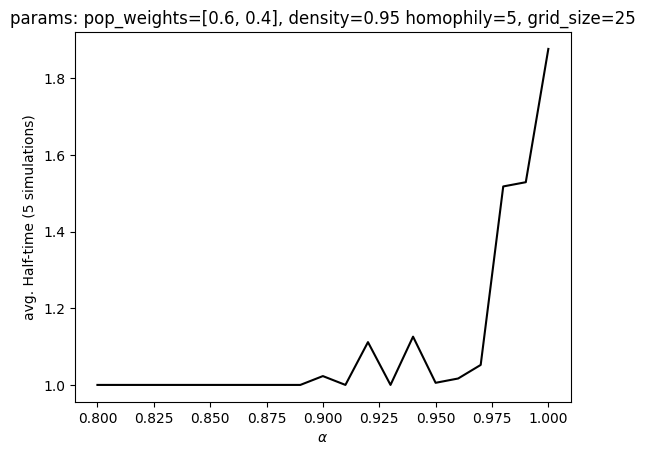

<Figure size 640x480 with 0 Axes>

In [19]:
sims = 5  # Number of model runs

# Define model parameters
size = 25
density = 0.95
homophily = 5
fixed_areas_pc = 0.0
population_sizes = [0.6, 0.4] # Add extra weights for more agent types (up to 10)
cluster_threshold = 4
stopping_threshold=5
stats = True
server=False

alpha_range = np.linspace(0.8, 1, num=21)
print(f'For alpha values: {alpha_range}')

half_time_list = []
for alpha in tqdm(alpha_range):
    alpha_half_time = []

    for _ in range(sims):
        model = Schelling(size, density, fixed_areas_pc, population_sizes, homophily, cluster_threshold, alpha, stopping_threshold, stats, server)        
        for i in range(100):
            model.step()
        
        half_time = model.half_time
        alpha_half_time.append(half_time)

    average_half_time = np.mean(alpha_half_time)
    half_time_list.append(average_half_time)

plt.plot(alpha_range, half_time_list, 'k-')
plt.title(f'params: pop_weights={population_sizes}, density={density} homophily={homophily}, grid_size={size}')
plt.xlabel(r"$\alpha$")
plt.ylabel(f'avg. Half-time ({num_runs} simulations)')
plt.show()
plt.savefig('RQ3_HalfTime_vs_Alpha.png')

### Sub-RQ4: *Is wealth clustering correlated to segregation clustering?*

In [15]:
sims = 5  # Number of model runs

# Define model parameters
size = 25
homophily = 5
fixed_areas_pc = 0.0
population_sizes = [0.6, 0.4]
cluster_threshold = 4
stopping_threshold = 5
stats = True
server = False

alpha_range = np.linspace(0.96, 0.99, num=5)
density_range = np.linspace(0.7,0.95, num=5)
print(f'For alphas={alpha_range}\nFor densities={density_range}')

half_time_list = []
MoransI_list = []

for alpha in tqdm(alpha_range):
    for density in density_range:
        alpha_half_time = []
        alpha_MoransI = []

        for _ in range(sims):
            model = Schelling(size, density, fixed_areas_pc, population_sizes, homophily, cluster_threshold, alpha, stopping_threshold, stats, server)
            
            for i in range(100):
                model.step()

            alpha_half_time.append(model.half_time)
            alpha_MoransI.append(MoransI(model))

        average_half_time = np.mean(alpha_half_time)
        average_MoransI = np.mean(alpha_MoransI)

        half_time_list.append(average_half_time)
        MoransI_list.append(average_MoransI)

# Finding correlation between MoransI and half-time
r = np.corrcoef(half_time_list, MoransI_list)
print(f'Pearson correlation coefficient between half-time and MoransI is: {r[0,1]}')


For alphas=[0.96   0.9675 0.975  0.9825 0.99  ]
For densities=[0.7    0.7625 0.825  0.8875 0.95  ]


100%|██████████| 5/5 [01:16<00:00, 15.30s/it]

Pearson correlation coefficient between half-time and MoransI is: 0.2674845004593157


# 4. Criticality:

In [17]:
def create_percolation_prob_dict(grouped_df, variable):
    # Create a dictionary to store the probabilities
    probability_dict = {}
    for index, row in grouped_df.iterrows():
        size = row['size']
        value = row[variable]
        probability = row['percolation_system']
        key = f"{size} x {size}"
        if key not in probability_dict:
            probability_dict[key] = []
        probability_dict[key].append(probability)
    return probability_dict

def extract_data(data_dict):
    x = np.array(list(data_dict.values())[0])
    y = np.zeros((len(data_dict), len(x)))
    for i in range(len(data_dict)):
        y[i] = np.array(list(data_dict.values())[i])

    return x, y

def plot_percolation_prob(densities, probability_dict, variable):
 
    for key in probability_dict:
        plt.plot(densities, probability_dict[key], label=f"Grid size = {key}")
        plt.title(f"Percolation probability vs {variable}")
        plt.xlabel(variable)
        plt.ylabel("Percolation probability")
        plt.legend()
    plt.show()

def derivative(x, y):
    derivative = np.zeros((y.shape[0], y.shape[1]-1))
    for i in range(y.shape[1]-1):
        for j in range(y.shape[0]):
            derivative[j,i] = (y[j,i] - y[j,i+1]) / (x[i] - x[i+1])
    return derivative

def plot_first_derivative(densities, probability_dict, variable):

    # Convert densities    
    x = np.array(densities)

    # Covert probabilities in dictionary to numpy array
    y = []
    for key in probability_dict.keys():
        y.append(probability_dict[key])
    y = np.array(y)

    # Calculate first derivative
    first_der = derivative(x, y)

    # Plot first derivative
    for i in range(len(y)):
        plt.plot(x[:-1],first_der[i,:], label=f"Grid size = {list(probability_dict.keys())[i]}")
        plt.title(f"First-order Derivative of Percolation probability vs {variable}")
        plt.xlabel(variable)
        plt.ylabel("Percolation probability")
        plt.legend()
    plt.show()

def plot_second_derivative(densities, probability_dict, variable):

    # Convert densities    
    x = np.array(densities)

    # Covert probabilities in dictionary to numpy array
    y = []
    for key in probability_dict.keys():
        y.append(probability_dict[key])
    y = np.array(y)

    # Calculate first derivative
    first_der = derivative(x, y)
    # Calculate second derivative
    second_der = derivative(x,first_der)

    # Plot first derivative
    for i in range(len(y)):
        plt.plot(x[:-2],second_der[i,:], label=f"Grid size = {list(probability_dict.keys())[i]}")
        plt.title(f"Second-order Derivative of Percolation probability vs {variable}")
        plt.xlabel(variable)
        plt.ylabel("Percolation probability")
        plt.legend()
    plt.show()

### Sub-RQ5: *What is the **critical population density** where percolation happens?* 

In [49]:
# NOTE: You don't need to run this because the results are already saved in the data folder
sims = 5
grid_size_range = np.linspace(25, 75, num=3, dtype=int)
density_range = np.linspace(0.85, 0.99, num=15)

print(f'For grid sizes={grid_size_range}\nFor densities={density_range}')

fixed_params = {"pop_weights": (0.6, 0.4),
                "fixed_areas_pc": 0.0, 
                "cluster_threshold": 4, 
                "alpha": 0.96, 
                "homophily": 5, 
                "stopping_threshold": 5,
                "stats": True,
                "server": False}
variable_params = {
    "size": grid_size_range,
    "density": density_range
}

batch_run = BatchRunner(
    Schelling,
    variable_params,
    fixed_params,
    iterations=sims,
    max_steps=100,
    model_reporters={"percolation_system": lambda m: m.percolation_system, 
                     "stopping_step": lambda m: m.schedule.steps,
                     "segregation_coefficient": lambda m: m.segregation_coefficient,
                     "half_time": lambda m: m.half_time,
                     }
)

batch_run.run_all()
df = batch_run.get_model_vars_dataframe()
df.to_csv('critical_pop_dens_batch_run.csv')

/var/folders/zt/xg8vn6kd28d6d7986gygz89r0000gn/T/ipykernel_33568/4219934424.py:21: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(


For grid sizes=[25 50 75]
For densities=[0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]


225it [23:49,  6.35s/it]


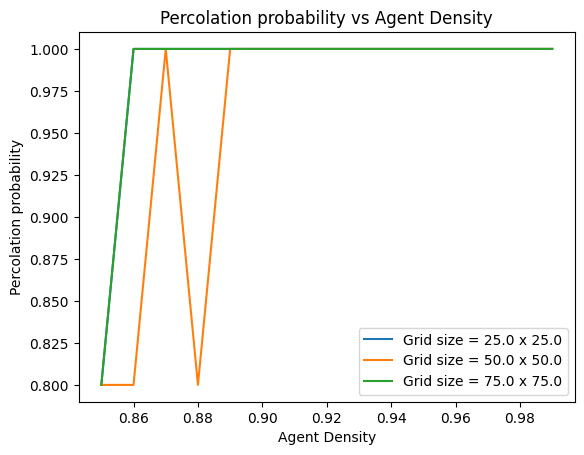

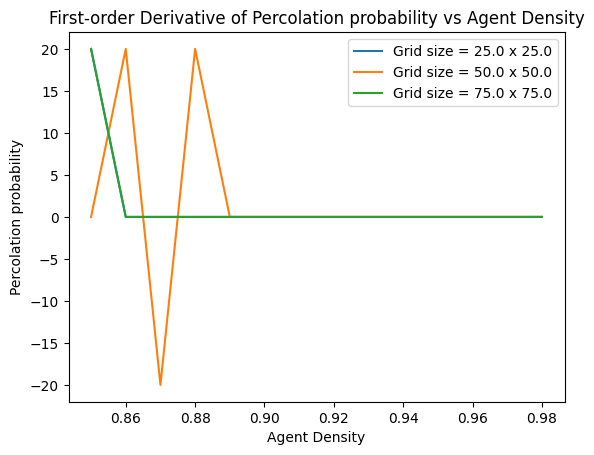

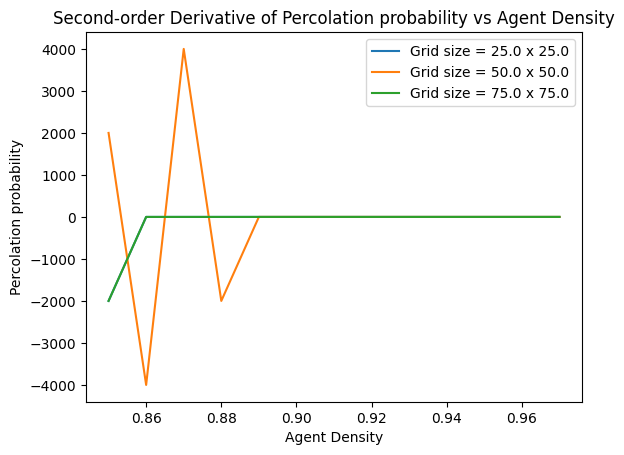

In [19]:
# Open the csv file and read it into a DataFrame
df = pd.read_csv("batch_runner_results/critical_pop_dens_batch_run.csv", index_col=0)

# Group the DataFrame by size and density and calculate the probability of percolation
grouped_df = df.groupby(['size', 'density'])['percolation_system'].mean().reset_index()

# Extract the data from the DataFrame
probability_dict = create_percolation_prob_dict(grouped_df, 'density')
densities = grouped_df['density'].unique()
    
# Plot the data
plot_percolation_prob(densities, probability_dict, 'Agent Density')
plot_first_derivative(densities, probability_dict, 'Agent Density')
plot_second_derivative(densities, probability_dict, 'Agent Density')

### Sub-RQ6: *What is the **critical tolerance threshold** where percolation happens?*

In [43]:
# NOTE: You don't need to run this because the results are already saved in the data folder
sims = 5
grid_size_range = np.linspace(25, 75, num=3, dtype=int)
homophily_range = np.linspace(1, 8, num=8, dtype=int)
print(f'For grid sizes={grid_size_range}\nFor homophilies={homophily_range}')

fixed_params = {"density": 0.95,
                "pop_weights": (0.6, 0.4),
                "fixed_areas_pc": 0.0, 
                "cluster_threshold": 4, 
                "alpha": 0.96, 
                "stopping_threshold": 5,
                "stats": True,
                "server": False}
variable_params = {
    "size": grid_size_range,
    "homophily": homophily_range
}

batch_run = BatchRunner(
    Schelling,
    variable_params,
    fixed_params,
    iterations=sims,
    max_steps=5,
    model_reporters={"percolation_system": lambda m: m.percolation_system, 
                     "stopping_step": lambda m: m.schedule.steps,
                     "segregation_coefficient": lambda m: m.segregation_coefficient,
                     "half_time": lambda m: m.half_time,
                     }
)

batch_run.run_all()
df = batch_run.get_model_vars_dataframe()
df.to_csv('critical_homophily_batch_run.csv')

/var/folders/zt/xg8vn6kd28d6d7986gygz89r0000gn/T/ipykernel_33568/3398494717.py:19: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(


For grid sizes=[10 30 50]
For homophilies=[1 2 3 4 5 6 7 8]


72it [01:37,  1.35s/it]


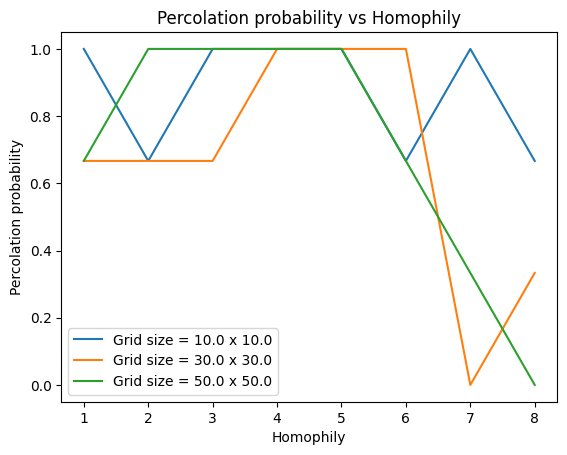

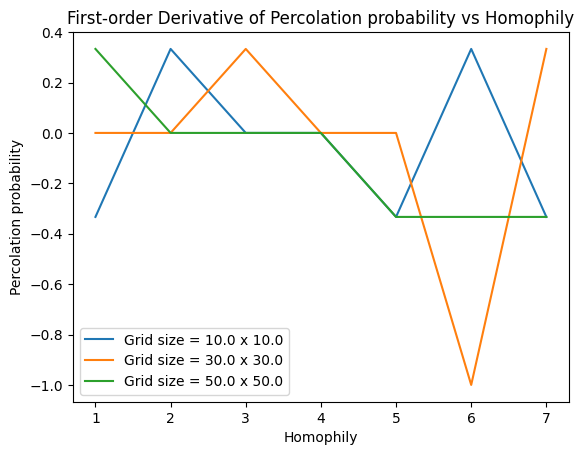

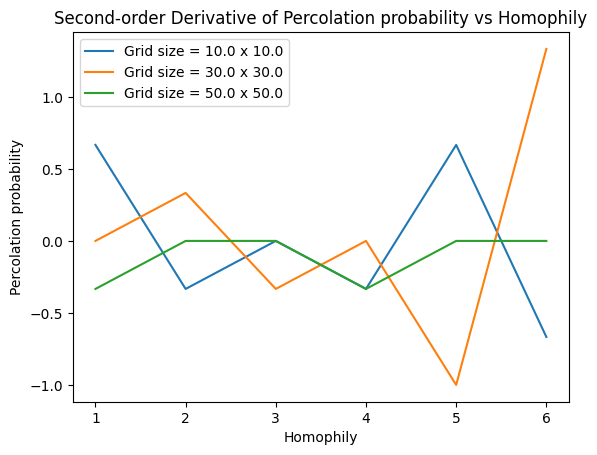

In [20]:
# Open the csv file and read it into a DataFrame
df = pd.read_csv("batch_runner_results/critical_homophily_batch_run.csv", index_col=0)

# Group the DataFrame by size and density and calculate the probability of percolation
grouped_df = df.groupby(['size', 'homophily'])['percolation_system'].mean().reset_index()

# Extract the data from the DataFrame
probability_dict = create_percolation_prob_dict(grouped_df, 'homophily')
homophilies = grouped_df['homophily'].unique()
    
# Plot the data
plot_percolation_prob(homophilies, probability_dict, 'Homophily')
plot_first_derivative(homophilies, probability_dict, 'Homophily')
plot_second_derivative(homophilies, probability_dict, 'Homophily')

### Sub-RQ7: *What is the **critical alpha** where wealth clustering happens?* 

In [6]:
def derivative2(x,y):
    derivative = np.zeros((len(x)))
    for i in range(len(x)-1):
        derivative[i] = (y[i] - y[i+1]) / (x[i] - x[i+1])
    return derivative

In [8]:
sims = 5
grid_size_range = np.linspace(10, 50, num=3, dtype=int)
alpha_range = np.linspace(0.90, 1, num=8)
print(f'For grid sizes={grid_size_range}\nFor aplhas={alpha_range}')

fixed_params = {"density": 0.95,
                "pop_weights": (0.6, 0.4),
                "fixed_areas_pc": 0.0, 
                "cluster_threshold": 4,  
                "homophily": 5, 
                "stopping_threshold": 5,
                "stats": True,
                "server": False}
variable_params = {
    "size": grid_size_range,
    "alpha": alpha_range
}

batch_run = BatchRunner(
    Schelling,
    variable_params,
    fixed_params,
    iterations=sims,
    max_steps=100,
    model_reporters={"percolation_system": lambda m: m.percolation_system, 
                     "stopping_step": lambda m: m.schedule.steps,
                     "segregation_coefficient": lambda m: m.segregation_coefficient,
                     "half_time": lambda m: m.half_time,
                     }
)

batch_run.run_all()
df = batch_run.get_model_vars_dataframe()
df.to_csv('critical_alpha_batch_run.csv')

C:\Users\mirja\AppData\Local\Temp\ipykernel_17064\2922923597.py:19: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(


For grid sizes=[10 30 50]
For aplhas=[0.9        0.91428571 0.92857143 0.94285714 0.95714286 0.97142857
 0.98571429 1.        ]


120it [10:02,  5.02s/it]


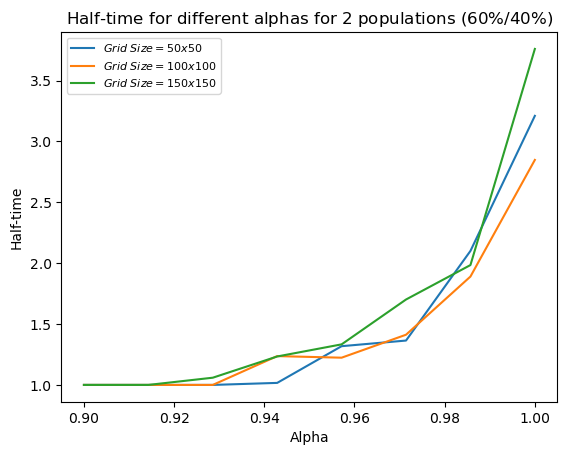

In [12]:
# Open the csv file and read it into a DataFrame
# NOTE: the csv file accessed here was run for bigger grid sizes than the above code (that takes hours to run)
df = pd.read_csv("batch_runner_results/critical_alpha_batch_run.csv")

# Group the DataFrame by alpha and size and calculate the sum of half_time
grouped_df = df.groupby(['alpha', 'size'])['half_time'].sum().reset_index()
grouped_df['half_time'] = grouped_df['half_time'] / sims

# Extract the unique values for alpha and size
alpha_values = grouped_df['alpha'].unique()
size_values = grouped_df['size'].unique()

# Create an empty array to store the half-times
half_time_counts = np.zeros((len(size_values), len(alpha_values)))
for i, n in enumerate(size_values):
    for j, h in enumerate(alpha_values):
        mask = (grouped_df['alpha'] == h) & (grouped_df['size'] == n)
        half_time_counts[i, j] = grouped_df.loc[mask, 'half_time']


# Plot the half-time results
for i, size in enumerate(size_values):
    plt.title(r'Half-time for different alphas for 2 populations $(60\%/40\%)$')
    plt.plot(alpha_values, half_time_counts[i], label=r'$Grid\ Size = %i x %i$' % (size, size))

plt.xlabel('Alpha')
plt.ylabel('Half-time')
plt.legend(prop={'size': 8})
plt.show()

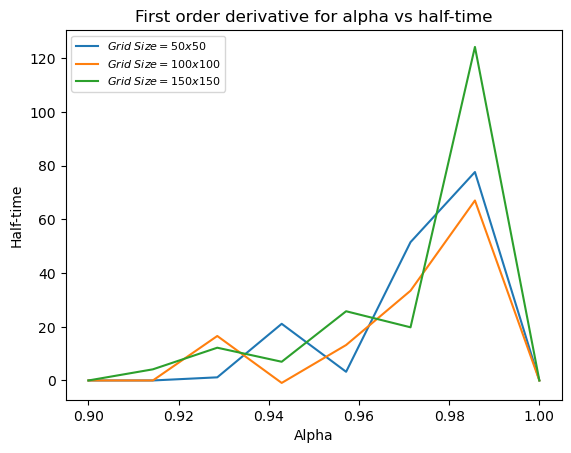

In [13]:
# Calculating and plotting first-order derivative
first_deriv = np.zeros((3,8))

first_deriv[0] = derivative2(alpha_values, half_time_counts[0])
first_deriv[1] = derivative2(alpha_values, half_time_counts[1])
first_deriv[2] = derivative2(alpha_values, half_time_counts[2])

# Plot the first order derivative
for i, size in enumerate(size_values):
    plt.title('First order derivative for alpha vs half-time')
    plt.plot(alpha_values, first_deriv[i], label=r'$Grid\ Size = %i x %i$' % (size, size))

plt.xlabel('Alpha')
plt.ylabel('Half-time')
plt.legend(prop={'size': 8})
plt.show()

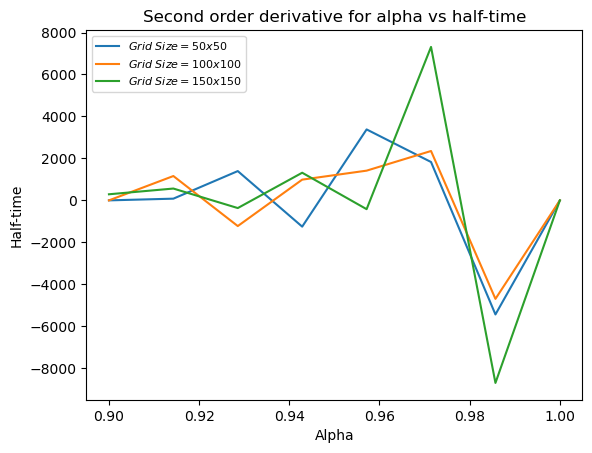

In [14]:
# Calculating and plotting second-order derivative
second_deriv = np.zeros((3,8))

second_deriv[0] = derivative2(alpha_values, first_deriv[0])
second_deriv[1] = derivative2(alpha_values, first_deriv[1])
second_deriv[2] = derivative2(alpha_values, first_deriv[2])

# Plot the second order derivative
for i, size in enumerate(size_values):
    plt.title('Second order derivative for alpha vs half-time')
    plt.plot(alpha_values, second_deriv[i], label=r'$Grid\ Size = %i x %i$' % (size, size))

plt.xlabel('Alpha')
plt.ylabel('Half-time')
plt.legend(prop={'size': 8})
plt.show()

# 5. Interaction between alpha and (homophily/agent density)

In [21]:
def extract_half_time(df, x1, x2, variable):
    half_time = np.zeros((len(x1), len(x2)))

    for i, n in enumerate(x1):
        for j, h in enumerate(x2):
            mask = (df[variable] == h) & (df['alpha'] == n)
            if mask.any():
                half_time[i, j] = df.loc[mask, 'half_time'].iloc[0]
            
    return half_time

def plot_phase_diagram(x1, x2, y, variable, sims, gridsize):
    
    plt.imshow(y, cmap="magma", origin="lower")
    plt.xticks(range(len(x1)), x1)
    plt.yticks(range(len(x2)), x2)
    plt.colorbar(label=f'Half time ({sims} sims)')
    plt.ylabel(r"$\alpha$")
    plt.xlabel(variable)
    plt.xticks(rotation=45)
    plt.title(f"Phase diagram of Half time (grid_size={gridsize})")
    plt.savefig("RQx_Alpha_var_Halftime.png", dpi = 200)
    plt.show()

### Sub-RQ8: *What is the effect of alpha and homophily on the halftime?*

In [21]:
# NOTE: You don't need to run this because the results are already saved in the data folder
sims = 5
alpha_range = np.linspace(0.95, 1, num=6)
homophily_range = np.linspace(1, 8, num=8, dtype=int)
print(f'For alphas={alpha_range}\nFor homophilies={homophily_range}')

fixed_params = {
                "size": 25,
                "density": 0.97,
                "pop_weights": (0.6, 0.4),
                "fixed_areas_pc": 0.0, 
                "cluster_threshold": 4, 
                "stopping_threshold": 5,
                "stats": True,
                "server": False}
variable_params = {
    "alpha": alpha_range,
    "homophily": homophily_range
}

batch_run = BatchRunner(
    Schelling,
    variable_params,
    fixed_params,
    iterations=sims,
    max_steps=100,
    model_reporters={"percolation_system": lambda m: m.percolation_system, 
                     "stopping_step": lambda m: m.schedule.steps,
                     "total_avg_cluster_size": lambda m: m.total_avg_cluster_size,
                     "segregation_coefficient": lambda m: m.segregation_coefficient,
                     "half_time": lambda m: m.half_time,
                     }
)

batch_run.run_all()
df = batch_run.get_model_vars_dataframe()
df.to_csv('alpha_homophily_batch_run.csv')

/var/folders/zt/xg8vn6kd28d6d7986gygz89r0000gn/T/ipykernel_33568/2135068988.py:20: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(


For alphas=[0.95 0.96 0.97 0.98 0.99 1.  ]
For homophilies=[1 2 3 4 5 6 7 8]


240it [01:38,  2.43it/s]


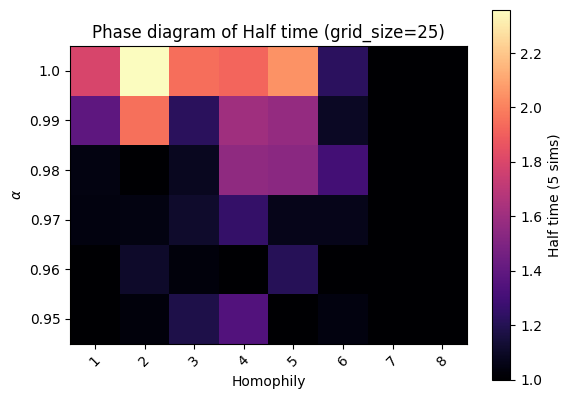

In [26]:
df = pd.read_csv("batch_runner_results/alpha_homophily_batch_run.csv", index_col=0)

grouped_df = df.groupby(['homophily', 'alpha'])['half_time'].mean().reset_index()

alpha_values = grouped_df['alpha'].round(2).unique()
homophily_values = grouped_df['homophily'].round(2).unique()
half_time = extract_half_time(grouped_df, alpha_values, homophily_values, 'homophily')

plot_phase_diagram(homophily_values, alpha_values, half_time, 'Homophily', sims, 25)


### Sub-RQ9: *What is the effect of alpha and agent density on the halftime?*

In [37]:
# NOTE: You don't need to run this because the results are already saved in the data folder
sims = 5
alpha_range = np.linspace(0.95, 1, num=6)
density_range = np.linspace(0.85, 0.99, num=15)
print(f'For alphas={alpha_range}\nFor densities={density_range}')

fixed_params = {
                "size": 25,
                "pop_weights": (0.6, 0.4),
                "homophily": 5,
                "fixed_areas_pc": 0.0, 
                "cluster_threshold": 4, 
                "stopping_threshold": 5,
                "stats": True,
                "server": False}
variable_params = {
    "alpha": alpha_range,
    "density": density_range,
}

batch_run = BatchRunner(
    Schelling,
    variable_params,
    fixed_params,
    iterations=sims,
    max_steps=100,
    model_reporters={"percolation_system": lambda m: m.percolation_system, 
                     "stopping_step": lambda m: m.schedule.steps,
                     "total_avg_cluster_size": lambda m: m.total_avg_cluster_size,
                     "segregation_coefficient": lambda m: m.segregation_coefficient,
                     "half_time": lambda m: m.half_time,
                     }
)

batch_run.run_all()
df = batch_run.get_model_vars_dataframe()
df.to_csv('alpha_density_batch_run.csv')

/var/folders/zt/xg8vn6kd28d6d7986gygz89r0000gn/T/ipykernel_33568/1645673584.py:20: DeprecationWarning: BatchRunner class has been replaced by batch_run function. Please see documentation.
  batch_run = BatchRunner(


For alphas=[0.95 0.96 0.97 0.98 0.99 1.  ]
For densities=[0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]


450it [03:16,  2.29it/s]


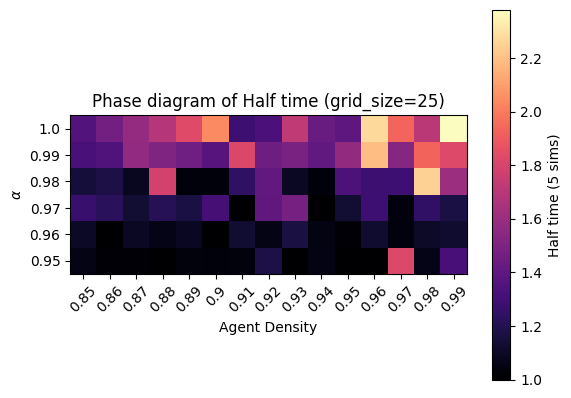

In [28]:
df = pd.read_csv("batch_runner_results/alpha_density_batch_run.csv", index_col=0)

grouped_df = df.groupby(['density', 'alpha'])['half_time'].mean().reset_index()

alpha_values = grouped_df['alpha'].round(2).unique()
density_values = grouped_df['density'].round(2).unique()
half_time = extract_half_time(grouped_df, alpha_values, density_values, 'density')

plot_phase_diagram(density_values, alpha_values, half_time, 'Agent Density', sims, 25)